# Quantum Kernel Methods for Classification using Covalent

Using quantum kernels for spam detection.

#### Referenced Tutorials
1. https://covalent.readthedocs.io/en/latest/tutorials/1_QuantumMachineLearning/classical_quantum_svm/source.html
2. https://covalent.readthedocs.io/en/latest/tutorials/1_QuantumMachineLearning/quantum_embedding_kernel/source.html

In [15]:
import os
import pandas as pd
import numpy as np
import numpy as np
from sklearn import decomposition
import csv
import pickle as pk
from process_data import read_data

# Import Workflow Manager (Covalent)
import covalent as ct

# Import plotting library
import matplotlib.pyplot as plt

# Set global plot background color
plt.rcParams["figure.facecolor"] = "w"

# Import for SVM classifier
from sklearn.svm import SVC

# Imports for dataset and model selection
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Imports for QSVC classifier
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Session

# Set the random seed for QSVC
seed = 12345
algorithm_globals.random_seed = seed

# token to access IBM Quantum compute resources
IBM_QUANTUM_TOKEN="123456789qwertyuiopzxcvbnmasdfghjkl"

In [153]:
def load_data(nsize=100):
    X, y = read_data("./data/spambase.csv", target_features=2)
    rand = np.random.permutation(len(y))
#     X = X[rand]
#     y = y[rand]
    x_filename = './data/X.pkl'
    y_filename = './data/y.pkl'
    with open(x_filename, "wb") as fd:
        pk.dump(X[::int(len(y)/nsize)], fd)
    with open(y_filename, "wb") as fd:
        pk.dump(y[::int(len(y)/nsize)], fd)
    return 
load_data()

In [145]:
# Ancillary functions for SVM classifiers

#@ct.electron
def get_data():
    x_filename = './data/X.pkl'
    y_filename = './data/y.pkl'
    filex = open(x_filename, 'rb')
    X = pk.load(filex)
    filey = open(y_filename, 'rb')
    y = pk.load(filey)
    return X, y


#@ct.electron
def split_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    return X_train, X_test, y_train, y_test


#@ct.electron
def train_svc(X_train, y_train):
    svc = SVC(kernel="linear")
    svc.fit(X_train, y_train)
    return svc


#@ct.electron
# def define_backend():
#     QiskitRuntimeService.save_account(channel="ibm_quantum",
#                                       token=IBM_QUANTUM_TOKEN,
#                                       instance="ibm-q-community/mit-hackathon/main",
#                                       overwrite=True)
#     return Session(service=QiskitRuntimeService(), backend="ibm_oslo")

#@ct.electron
def train_qsvc(X_train, y_train):
    feature_map = ZZFeatureMap(2, reps=2, entanglement="linear")
    backend = QuantumInstance(
        BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
    )
    kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
    qsvc = SVC(kernel=kernel.evaluate)
    qsvc.fit(X_train, y_train)
    return qsvc

# Main Workflow
#@ct.lattice
def workflow():
    X, y = get_data()
    X_train, X_test, y_train, y_test = split_train_test(X=X, y=y)
    svc_model = train_svc(X_train=X_train, y_train=y_train)
    qsvc_model = train_qsvc(X_train=X_train, y_train=y_train)
    return y_train, X_test, y_test, svc_model, qsvc_model


In [146]:
# Dispatch workflow and obtain results
#dispatch_id = ct.dispatch(workflow)()
#result = ct.get_result(dispatch_id=dispatch_id, wait=True)
result = workflow()

In [147]:
print(result)

(array([ 1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1,
       -1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1,
        1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1,
       -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1,  1,  1,
       -1,  1, -1, -1, -1, -1, -1]), array([[-1.11048015,  1.54109438],
       [ 0.91904044, -3.22691904],
       [-1.68094869,  4.63943916],
       [-0.16072776, -0.59633228],
       [-0.70327704, -0.2128961 ],
       [-0.65811151, -0.84465317],
       [-0.5184217 , -0.18213792],
       [ 1.83076909, -0.90869763],
       [ 6.56870328, -0.37127758],
       [-0.30436612, -0.89132365],
       [-0.62368446, -0.71956352],
       [ 1.30222405, -0.17103847],
       [-0.11447439, -2.22333858],
       [-0.6230652 ,  0.01768653],
       [-0.83464078,  0.40096582],
       [-0.61722297, -0.02169801],
       [-0.8804098 ,  0.63480102],
       [-1.48098186,  3.58228831],
       [-0.7939124 ,  0.83985305

In [148]:
#X_test, y_test, svc_model, qsvc_model = result.result
y_train, X_test, y_test, svc_model, qsvc_model = result

In [149]:
np.average(y_train)

-0.22666666666666666

In [150]:
X = X_test[0]
qsvc_model.predict(X)


array([1])

Text(0.5, 1.0, 'SVC confusion matrix plot')

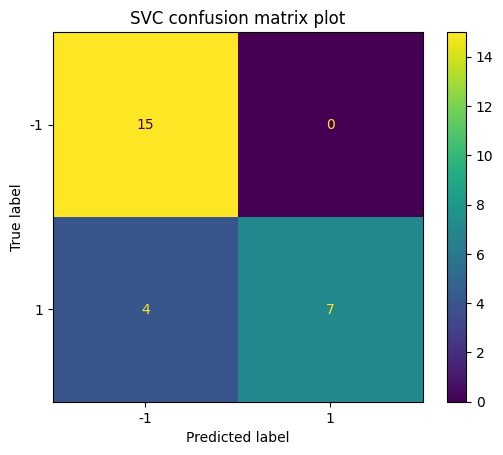

In [151]:
# Results from SVC
svc_cm_plot = ConfusionMatrixDisplay.from_estimator(svc_model, X_test, y_test)
svc_cm_plot.ax_.set_title("SVC confusion matrix plot")


Text(0.5, 1.0, 'QSVC confusion matrix plot')

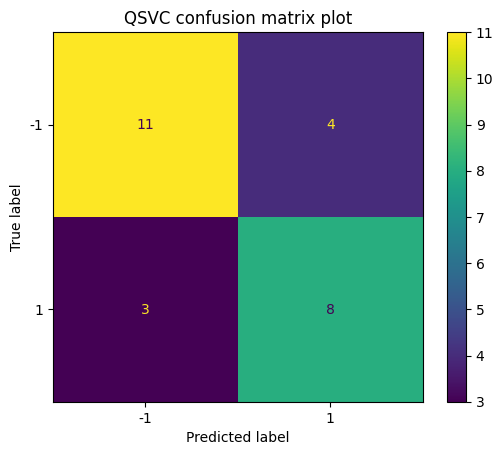

In [152]:
# Results from QSVC
qsvc_cm_plot = ConfusionMatrixDisplay.from_estimator(qsvc_model, X_test, y_test)
qsvc_cm_plot.ax_.set_title("QSVC confusion matrix plot")


In [155]:
file = "./models/svc.pkl"
with open(file, "wb") as fd:
    pk.dump(svc_model, fd)

In [156]:
file = "./models/qsvc.pkl"
with open(file, "wb") as fd:
    pk.dump(qsvc_model, fd)